In [2]:
from tqdm import tqdm
from sys import stdout
import pandas as pd 

import igraph as ig

import numpy as np
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
from tqdm import tqdm
import igraph as ig
import numpy as np
from numpy.linalg import norm
from sys import stdout

class GrowingNeuralGas:
    
    def __init__(self, max_neurons, max_iter, max_age, eb, en, alpha, beta, l, dataset):
        '''
        ---------------------------------------------
        Growing Neural Gas' Parameter Declarations
        ---------------------------------------------
        1. max_neurons ; Maximum # of neurons generated by the network
        2. max_iter ; Maximum # of iterations the 
        3. max_age ; Maximum # of age 
        4. eb ; fraction of distance betweeen nearest neuron and input signal
        5. en ; fraction of distance betweeen neighboring neurons and input signal
        6. alpha ; multiplying scalar for local error
        7. beta ; multiplying scalar for global error
        8. l 
        9. dataset
        '''
        # Parameters declared by user
        self.max_neurons = max_neurons
        self.max_iter = max_iter
        self.max_age = max_age
        self.eb = eb
        self.en = en
        self.alpha = alpha
        self.beta = beta
        self.l = l
        self.dataset_original = dataset.copy()
        self.dataset = dataset.copy()
        self.verts_evolve = []
        self.edges_evolve = []
    
    def initialize_gng(self):
        '''
        Initialize Growing Neural Gas
        '''
        # Get random datapoints from target dataset
        t0 = np.random.randint(0, int(self.dataset.shape[0] / 2))
        t1 = np.random.randint(int(self.dataset.shape[0]/2), self.dataset.shape[0])
        
        # Initialize Growing Neural Gas 
        self.gng = ig.Graph()
        self.gng.add_vertex(weight = self.dataset[t0,:], error = 0)
        self.gng.add_vertex(weight = self.dataset[t1,:], error = 0)
        self.gng.add_edge(0, 1, age = 0)
        
    def learning_position(self):
        for _ in range(0, self.l):
            # Step 1. Get a random datapoint from target dataset
            t = np.random.randint(0, self.dataset.shape[0])
            random_input = self.dataset[t, :]

            # Step 2. Find 2 nearest neuron from random_input
            nearest_index =  np.array([norm(weight - random_input)**2 for weight in self.gng.vs['weight']]).argsort()
            neuron_s1 = self.gng.vs[nearest_index[0]]
            neuron_s2 = self.gng.vs[nearest_index[1]]     

            # Step 3. Increase the age of all neighboring edges from nearest neuron (neuron_s1)
            for edge_id in self.gng.incident(neuron_s1.index):
                self.gng.es[edge_id]['age'] += 1

            # Step 4. Add error to the nearest neuron 
            self.gng.vs[neuron_s1.index]['error'] += norm(neuron_s1['weight'] - random_input)

            # Step 5.1. Update position of nearest neuron
            neuron_s1['weight'] += (self.eb * (random_input - neuron_s1['weight']))
            # Step 5.2. Update position of nearest neuron's neighbors
            for neuron in self.gng.vs[self.gng.neighbors(neuron_s1.index)]:
                neuron['weight'] += (self.en * (random_input - neuron_s2['weight']))

            # Step 6. Update edge of nearest neurons
            EDGE_FLAG = self.gng.get_eid(neuron_s1.index, neuron_s2.index, directed = False, error = False)
            if EDGE_FLAG == -1: # FLAG for no edge detected
                self.gng.add_edge(neuron_s1.index, neuron_s2.index, age = 0)
            else:
                self.gng.es[EDGE_FLAG]['age'] = 0

            # Step 7.1. Delete aging edge 
            for edge in self.gng.es:
                src = edge.source
                tgt = edge.target
                if edge['age'] > self.max_age:
                    self.gng.delete_edges(edge.index)
            # Step 7.2. Delete isolated neuron
            for neuron in self.gng.vs:
                if len(self.gng.incident(neuron)) == 0:
                    self.gng.delete_vertices(neuron)

            # Step 8. Reduce global error
            for neuron in self.gng.vs:
                neuron['error'] *= self.beta

            # Step 9.1. Remove generated random input from target dataset
            self.dataset = np.delete(self.dataset, t, axis = 0)
            # Step 9.2. Reset dataset if datapoints are depleted 
            if self.dataset.shape[0] == 1:
                self.dataset = self.dataset_original.copy()
        
    def update_neuron(self):
        # Adding new neuron from previous learning
        if len(self.gng.vs) <= self.max_neurons:
            # Get neuron q and f
            error_index = np.array([error for error in self.gng.vs['error']]).argsort()
            neuron_q = self.gng.vs[error_index[-1]]
            error = np.array([(neuron['error'], neuron.index) for neuron in self.gng.vs[self.gng.neighbors(neuron_q.index)]])
            error = np.sort(error, axis = 0)
            neuron_f = self.gng.vs[int(error[-1, 1])]
            
            # Add neuron between neuron q and f
            self.gng.add_vertex(weight = (neuron_q['weight'] + neuron_f['weight']) / 2, error = 0)
            neuron_r = self.gng.vs[len(self.gng.vs) - 1]
            
            # Delete edge between neuron q and f
            self.gng.delete_edges(self.gng.get_eid(neuron_q.index, neuron_f.index))
            
            # Create edge between q-r and r-f
            self.gng.add_edge(neuron_q.index, neuron_r.index, age = 0)
            self.gng.add_edge(neuron_r.index, neuron_f.index, age = 0)
            
            # Update neuron error
            neuron_q['error'] *= self.alpha 
            neuron_f['error'] *= self.alpha
            neuron_r['error'] = neuron_q['error']
            
    def learn(self):
        # Initialize GNG
        self.initialize_gng()
        # GNG learning iteration
        for iter, _ in zip(range(0, self.max_iter), tqdm(range(self.max_iter))):
            # Track evolution
            self.verts_evolve.append(np.array([neuron['weight'] for neuron in self.gng.vs]))
            self.edges_evolve.append(np.array([(neuron.source + 1, neuron.target + 1) for neuron in self.gng.es]))
            # Learn new posititon
            self.learning_position()
            self.update_neuron()
            
        return self.gng
    
    def add_data_from_csv(self, csv_file):
        new_data = pd.read_csv(csv_file).values
        
        if len(new_data.shape) != 2:
            raise ValueError("Input data should have shape (n_samples, n_features).")
        
        if new_data.shape[1] != self.dataset_original.shape[1]:
            raise ValueError("Number of features in the new data should match the original dataset.")
        
        self.dataset_original = np.vstack((self.dataset_original, new_data))
        self.dataset = self.dataset_original.copy()
    
    def display_dataset(self):
        print(self.dataset)
        
    def predict(self, new_data):
        if self.gng is None:
            raise ValueError("Model has not been trained yet. Call the learn method first.")
        cluster_labels = [np.argmin([norm(data_point - neuron['weight']) for neuron in self.gng.vs]) for data_point in new_data]
        return cluster_labels

# Define your parameters
max_neurons = 100  # Example value, adjust as needed
max_iter = 1000   # Example value, adjust as needed
max_age = 100     # Example value, adjust as needed
eb = 0.05         # Example value, adjust as needed
en = 0.006        # Example value, adjust as needed
alpha = 0.5       # Example value, adjust as needed
beta = 0.0005     # Example value, adjust as needed
l = 10            # Example value, adjust as needed

# Load data from CSV
csv_file = "Credit_Card_Applications.csv"  # Path to your CSV file
dataset = pd.read_csv(csv_file).values

# Take a random sample of 100 data points
sampled_dataset = pd.DataFrame(dataset).sample(n=400, random_state=42).values

# Create an instance of GrowingNeuralGas
gng = GrowingNeuralGas(max_neurons, max_iter, max_age, eb, en, alpha, beta, l, sampled_dataset)

# Display the dataset
gng.display_dataset()


[[1.5782159e+07 0.0000000e+00 2.2670000e+01 ... 2.0000000e+02
  3.9500000e+02 0.0000000e+00]
 [1.5641715e+07 1.0000000e+00 1.9420000e+01 ... 8.0000000e+01
  2.9550000e+03 1.0000000e+00]
 [1.5704509e+07 1.0000000e+00 2.4580000e+01 ... 1.8400000e+02
  1.0000000e+00 0.0000000e+00]
 ...
 [1.5751137e+07 1.0000000e+00 3.3580000e+01 ... 2.0400000e+02
  1.0000000e+00 1.0000000e+00]
 [1.5636626e+07 1.0000000e+00 6.2750000e+01 ... 0.0000000e+00
  1.3000000e+01 0.0000000e+00]
 [1.5593959e+07 0.0000000e+00 2.1750000e+01 ... 1.6000000e+02
  1.0000000e+00 0.0000000e+00]]


In [4]:
import pandas as pd

# Load data from CSV
csv_file = "Credit_Card_Applications.csv"
data = pd.read_csv(csv_file)

# Display the column names
print(data.columns)


Index(['CustomerID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10', 'A11', 'A12', 'A13', 'A14', 'Class'],
      dtype='object')


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report



# Load the credit card application dataset
data = pd.read_csv("Credit_Card_Applications.csv")

# Separate features and target variable
X = data.drop(columns=['CustomerID', 'Class'])
y = data['Class']

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature extraction using Growing Neural Gas (GNG)
gng = GrowingNeuralGas(max_neurons=100, max_iter=1000, max_age=100, eb=0.05, en=0.006, alpha=0.5, beta=0.0005, l=10, dataset=X_train)
gng.learn()

# Predict cluster labels for training and test data points
train_cluster_labels = gng.predict(X_train)
test_cluster_labels = gng.predict(X_test)

# One-hot encode the cluster labels for training and test data points
features_train = pd.get_dummies(train_cluster_labels, prefix='cluster', columns=range(gng.max_neurons))
features_test = pd.get_dummies(test_cluster_labels, prefix='cluster', columns=range(gng.max_neurons))

# Align columns to ensure the same set of columns in both features_train and features_test
features_train, features_test = features_train.align(features_test, axis=1, fill_value=0)

# Model training and evaluation using Logistic Regression
model = LogisticRegression()
model.fit(features_train, y_train)

# Model evaluation
y_pred = model.predict(features_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


100%|█████████▉| 999/1000 [00:06<00:00, 153.20it/s]


Confusion Matrix:
[[31  8]
 [13 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.75        39
           1       0.78      0.68      0.73        41

    accuracy                           0.74        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.74      0.74      0.74        80



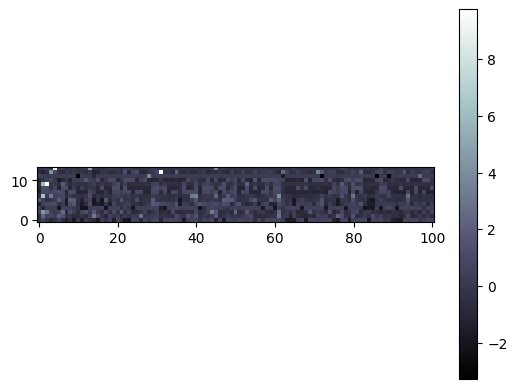

In [7]:
import matplotlib.pyplot as plt

# Visualisasi bobot neuron dari Growing Neural Gas (GNG)
plt.figure()
neuron_weights = [neuron['weight'] for neuron in gng.gng.vs]
neuron_weights = np.array(neuron_weights)
plt.imshow(neuron_weights.T, cmap='bone', origin='lower')
plt.colorbar()
plt.show()



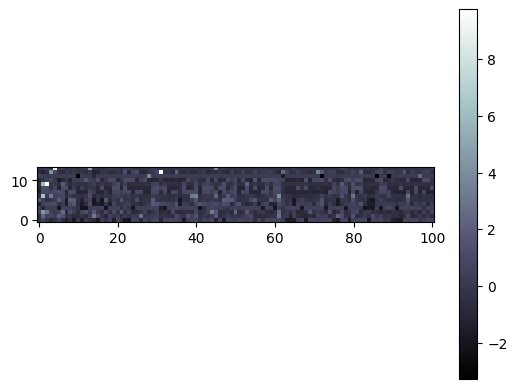

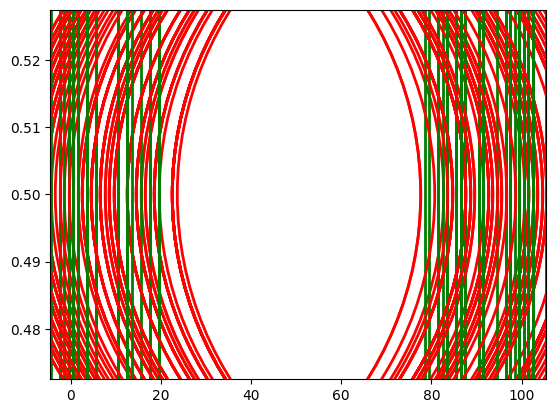

In [8]:
import matplotlib.pyplot as plt

# Visualisasi bobot neuron dari Growing Neural Gas (GNG)
plt.figure()
neuron_weights = [neuron['weight'] for neuron in gng.gng.vs]
neuron_weights = np.array(neuron_weights)
plt.imshow(neuron_weights.T, cmap='bone', origin='lower')
plt.colorbar()
plt.show()

# Plot lokasi neuron terdekat untuk setiap sampel
markers = ['o', 's']  # Jika observasi adalah fraud maka warna lingkaran merah atau hijau kotak
colors = ['r', 'g']
for i, x in enumerate(X_scaled):  # Pastikan X_scaled telah disesuaikan sebelumnya
    nearest_neuron_index = np.argmin([np.linalg.norm(x - np.array(neuron['weight'])) for neuron in gng.gng.vs])
    w = gng.gng.vs[nearest_neuron_index]
    plt.plot(w.index + 0.5,
             0.5,  # Pada GNG tidak ada koordinat vertikal, jadi kita tetapkan sebagai 0.5
             markers[int(y[i])],  # Menggunakan label sebagai indeks, pastikan y adalah numerik
             markeredgecolor=colors[int(y[i])],  # Menggunakan label sebagai indeks, pastikan y adalah numerik
             markerfacecolor='None',
             markersize=500,
             markeredgewidth=2)

plt.show()

In [9]:
X = np.array(X, dtype=np.float64)
# Initialize the mapping dictionary
mapping = {}

# Map each data point to the nearest neuron
for i, x in enumerate(X):
    # Find the index of the nearest neuron for the current data point
    nearest_neuron_index = np.argmin([np.linalg.norm(np.array(x) - np.array(neuron['weight'])) for neuron in gng.gng.vs])
    
    # Add the data point to the list associated with the nearest neuron index
    if nearest_neuron_index not in mapping:
        mapping[nearest_neuron_index] = []
    mapping[nearest_neuron_index].append(x)

# Print the mapping results
for neuron_index, data_points in mapping.items():
    print(f"Neuron {neuron_index}: {len(data_points)} data points")


Neuron 61: 26 data points
Neuron 31: 226 data points
Neuron 4: 139 data points
Neuron 1: 4 data points
Neuron 14: 4 data points
Neuron 45: 1 data points


In [45]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean

# Initialize the mapping dictionary
mapping = {}

# Map each data point to the nearest neuron
for i, x in enumerate(X):
    # Find the index of the nearest neuron for the current data point
    nearest_neuron_index = np.argmin([euclidean(x, neuron['weight']) for neuron in gng.gng.vs])
    
    # Add the data point to the list associated with the nearest neuron index
    if nearest_neuron_index not in mapping:
        mapping[nearest_neuron_index] = []
    mapping[nearest_neuron_index].append(i)  # Store the index i instead of the data point itself

# Create labels based on the mapping
labels = np.zeros(len(X))
for neuron_index, data_point_indices in mapping.items():
    labels[data_point_indices] = neuron_index

# Compute the Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: -0.08799268123354857


In [46]:
import numpy as np
from sklearn.metrics import pairwise_distances

def calculate_cluster_centers(gng):
    """
    Calculate the cluster centers of GNG.
    """
    cluster_centers = []
    for neuron in gng.gng.vs:
        cluster_centers.append(neuron['weight'])
    return np.array(cluster_centers)

def calculate_davies_bouldin_index(gng):
    """
    Calculate the Davies-Bouldin Index for GNG clustering.
    """
    # Calculate cluster centers
    cluster_centers = calculate_cluster_centers(gng)
    
    # Calculate pairwise distances between cluster centers
    cluster_distances = pairwise_distances(cluster_centers, cluster_centers)
    
    # Calculate the average intra-cluster distance for each cluster
    intra_cluster_distances = []
    for i, neuron_i in enumerate(gng.gng.vs):
        distances = []
        for j, neuron_j in enumerate(gng.gng.vs):
            if i != j:
                distances.append(np.linalg.norm(np.array(neuron_i['weight']) - np.array(neuron_j['weight'])))
        if distances:
            intra_cluster_distances.append(np.mean(distances))
        else:
            intra_cluster_distances.append(0)

    # Calculate the Davies-Bouldin Index
    db_index = 0
    for i, neuron_i in enumerate(gng.gng.vs):
        max_db = 0
        for j, neuron_j in enumerate(gng.gng.vs):
            if i != j:
                db = (intra_cluster_distances[i] + intra_cluster_distances[j]) / cluster_distances[i, j]
                if db > max_db:
                    max_db = db
        db_index += max_db
    db_index /= len(gng.gng.vs)

    return db_index

# Calculate Davies-Bouldin Index
db_index = calculate_davies_bouldin_index(gng)
print("Davies-Bouldin Index:", db_index)


Davies-Bouldin Index: 5.2455803516307045


In [10]:
mapping

{61: [array([ 0.   , 20.42 ,  0.835,  2.   , 11.   ,  4.   ,  1.585,  1.   ,
          1.   ,  1.   ,  0.   ,  2.   ,  0.   ,  1.   ]),
  array([ 1.   , 22.25 ,  9.   ,  2.   ,  6.   ,  4.   ,  0.085,  0.   ,
          0.   ,  0.   ,  0.   ,  2.   ,  0.   ,  1.   ]),
  array([ 0.   , 49.83 , 13.585,  2.   ,  4.   ,  8.   ,  8.5  ,  1.   ,
          0.   ,  0.   ,  1.   ,  2.   ,  0.   ,  1.   ]),
  array([ 0.   , 33.08 ,  1.625,  2.   ,  2.   ,  4.   ,  0.54 ,  0.   ,
          0.   ,  0.   ,  1.   ,  2.   ,  0.   ,  1.   ]),
  array([ 0.  , 56.83,  4.25,  1.  ,  1.  ,  1.  ,  5.  ,  0.  ,  0.  ,
          0.  ,  1.  ,  2.  ,  0.  ,  5.  ]),
  array([ 0.   , 33.08 ,  4.625,  2.   , 11.   ,  8.   ,  1.625,  1.   ,
          1.   ,  2.   ,  0.   ,  2.   ,  0.   ,  1.   ]),
  array([ 1. , 20. ,  7. ,  2. ,  8. ,  4. ,  0.5,  0. ,  0. ,  0. ,  0. ,
          2. ,  0. ,  1. ]),
  array([ 1.  , 31.57,  3.  ,  1.  ,  3.  ,  5.  ,  7.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  2.  ,  0.  ,  2.  

In [11]:
mapping.keys

<function dict.keys>

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data
data_path = 'Credit_Card_Applications.csv'  # Update with your path if needed
df = pd.read_csv(data_path)

# Drop the 'CustomerID' column as it's not needed for clustering
df.drop('CustomerID', axis=1, inplace=True)

# Separate features and the class label
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Output the first few rows of the normalized data
print(X_scaled[:5])



[[-1.44115338 -0.93435858 -0.79505283  0.52351283  0.98460036 -0.28262786
  -0.21541205  0.92295821  1.1055416  -0.28569378 -0.95118973  0.20412415
  -1.06160726 -0.23283391]
 [-1.44115338  0.55994888 -0.15280727  0.52351283  0.17533979 -0.28262786
   0.17902745 -1.08347268 -0.90453403 -0.47211713 -0.95118973  0.20412415
   1.6163662  -0.23283391]
 [ 0.69388867  0.52711576 -0.92187858  0.52351283 -0.90367431 -0.28262786
  -0.6335458   0.92295821 -0.90453403 -0.47211713  1.05131497  0.20412415
   0.50054392 -0.23283391]
 [ 0.69388867 -0.35377289  1.82567434  0.52351283  0.44509331 -0.28262786
   0.94560598  0.92295821 -0.90453403 -0.47211713  1.05131497  0.20412415
   1.65541998 -0.11849141]
 [ 0.69388867 -0.34736642 -0.84578313 -1.85609095  1.52410741 -0.28262786
  -0.58755109  0.92295821  1.1055416  -0.09927043 -0.95118973  0.20412415
   0.3889617  -0.11849141]]


In [26]:
mapping.keys()

dict_keys([61, 31, 4, 1, 14, 45])

In [17]:
# out of the 100 segments: 70 segments have customers and other 30 segments don't have any customers mapped to it 
len(mapping.keys())

6

In [28]:
nilai_61 = mapping[61]
nilai_4 = mapping[31]
nilai_0 = mapping[4]
nilai_2 = mapping[1]
nilai_3 = mapping[14]
nilai_95 = mapping[45]
nilai_40 = mapping[45]

In [34]:
mapping[(61)]
mapping[(4)]
mapping[(4)]
mapping[(1)]
mapping[14]
mapping[45]
mapping[45]

[array([ 1.   , 16.   ,  3.125,  2.   ,  9.   ,  4.   ,  0.085,  0.   ,
         1.   ,  1.   ,  0.   ,  2.   ,  0.   ,  7.   ])]

In [35]:
mapping[(61)]

[array([ 0.   , 20.42 ,  0.835,  2.   , 11.   ,  4.   ,  1.585,  1.   ,
         1.   ,  1.   ,  0.   ,  2.   ,  0.   ,  1.   ]),
 array([ 1.   , 22.25 ,  9.   ,  2.   ,  6.   ,  4.   ,  0.085,  0.   ,
         0.   ,  0.   ,  0.   ,  2.   ,  0.   ,  1.   ]),
 array([ 0.   , 49.83 , 13.585,  2.   ,  4.   ,  8.   ,  8.5  ,  1.   ,
         0.   ,  0.   ,  1.   ,  2.   ,  0.   ,  1.   ]),
 array([ 0.   , 33.08 ,  1.625,  2.   ,  2.   ,  4.   ,  0.54 ,  0.   ,
         0.   ,  0.   ,  1.   ,  2.   ,  0.   ,  1.   ]),
 array([ 0.  , 56.83,  4.25,  1.  ,  1.  ,  1.  ,  5.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  2.  ,  0.  ,  5.  ]),
 array([ 0.   , 33.08 ,  4.625,  2.   , 11.   ,  8.   ,  1.625,  1.   ,
         1.   ,  2.   ,  0.   ,  2.   ,  0.   ,  1.   ]),
 array([ 1. , 20. ,  7. ,  2. ,  8. ,  4. ,  0.5,  0. ,  0. ,  0. ,  0. ,
         2. ,  0. ,  1. ]),
 array([ 1.  , 31.57,  3.  ,  1.  ,  3.  ,  5.  ,  7.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  2.  ,  0.  ,  2.  ]),
 array([ 1.  , 2

In [36]:
frauds = np.concatenate((mapping[(61)], mapping[(4)]), axis = 0)

In [37]:
frauds

array([[0.0000e+00, 2.0420e+01, 8.3500e-01, ..., 2.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.0000e+00, 2.2250e+01, 9.0000e+00, ..., 2.0000e+00, 0.0000e+00,
        1.0000e+00],
       [0.0000e+00, 4.9830e+01, 1.3585e+01, ..., 2.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [1.0000e+00, 2.7580e+01, 2.0400e+00, ..., 2.0000e+00, 3.7000e+02,
        5.6100e+02],
       [1.0000e+00, 3.0170e+01, 6.5000e+00, ..., 2.0000e+00, 3.3000e+02,
        1.2010e+03],
       [0.0000e+00, 2.8670e+01, 1.0400e+00, ..., 2.0000e+00, 3.0000e+02,
        1.4310e+03]])

In [38]:
frauds.shape

(165, 14)

In [42]:
from sklearn.preprocessing import StandardScaler

# Membuat objek StandardScaler
sc = StandardScaler()

# Melakukan fitting pada data
sc.fit(X_train)  # Misalnya, X_train adalah data yang digunakan untuk fitting

# Melakukan transformasi pada data
X_train_scaled = sc.transform(X_train)

# Melakukan inversi transformasi pada data yang telah ditransformasi
X_train_original = sc.inverse_transform(X_train_scaled)


# Melakukan inversi transformasi
frauds1 = sc.inverse_transform(frauds)


In [43]:
pd.DataFrame(frauds1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.013344,20.287695,0.830276,1.997842,11.100772,3.942346,1.581390,0.965888,0.979082,1.048717,-0.031289,1.919532,0.004910,1.094854
1,1.008256,22.104991,9.106690,1.997842,6.075658,3.942346,0.077796,-0.036367,-0.018844,-0.006059,-0.031289,1.919532,0.004910,1.094854
2,0.013344,49.493520,13.754254,1.997842,4.065612,7.890973,8.512958,0.965888,-0.018844,-0.006059,0.966653,1.919532,0.004910,1.094854
3,0.013344,32.859805,1.631056,1.997842,2.055567,3.942346,0.533886,-0.036367,-0.018844,-0.006059,0.966653,1.919532,0.004910,1.094854
4,0.013344,56.444924,4.291875,1.011563,1.050544,0.980876,5.004572,-0.036367,-0.018844,-0.006059,0.966653,1.919532,0.004910,5.421236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1.008256,55.541241,11.640804,1.997842,1.050544,0.980876,5.004572,0.965888,0.979082,5.267820,-0.031289,1.919532,0.004910,9574.297072
161,1.008256,50.983107,10.120336,1.997842,3.060589,4.929503,-0.007408,0.965888,0.979082,11.596474,-0.031289,1.919532,0.004910,1352.007697
162,1.008256,27.397988,2.051719,1.011563,6.075658,3.942346,1.997384,0.965888,0.979082,3.158268,0.966653,1.919532,383.432443,606.788362
163,1.008256,29.970007,6.572577,1.997842,13.110817,3.942346,3.125079,0.965888,0.979082,8.432147,-0.031289,1.919532,341.980817,1299.009515
